# Importing Libraries 

In [296]:
#importing libraries
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import boto3
from datetime import datetime
import sagemaker
from sagemaker import get_execution_role
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import PredefinedSplit
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

# Problem Statement 

How can we determine the popularity of a song based on its features? 

# 1. Exploratory data analysis and Feature Engineering

## 1.1 Dataset information from Spotify 

Spotify has provided information of each attribute on their website. The attribute information can be found here: https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-track 
Following are the attributes and their types:
- id: string
- name: string, name of the song
- populariy:continuous, ranging from 0 to 100
- duration_ms: continuous, duration of the song in ms
- explicit: categorical, determines whether the song contains explicit content or not (0/1)
- artists: list of strings, names of the artists
- id_artists: list of strings, ids of the artists
- release_date: date
- danceability: continuous, determines how suitable is the song for dancing (ranges from 0 to 1)
- energy: continuous, determined how energetic is the song (ranges from 0 to 1)
- key: categorical, major key of the track with 11 unique values
- loundness: continous, value in dB
- mode: categorical, track is major (1) or minor (0)
- speechiness: continous, ratio of spoken words to overall, 0(instrumental) and 1 (talk show)
- accousticness: continous
- instrumentalness: continous
- liveness: continous, 0 (studio recorded) and 1(concert)
- valence: continous, how positive is the music 0 (sad) and 1 (cheerful)
- tempo: continous, tempo of track in BPM
- time_signature: continous, specifies how many beats are in each bar

## 1.2 Importing data 
The data is available on: : https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks <br>
The dataset has been filtered for only 1990-2021 records. 

In [2]:
#importing the data
df = pd.read_csv("spotify_tracks.csv")

## 1.3 High-level overview 

In [3]:
df.head(2)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,['Gerry & The Pacemakers'],['3UmBeGyNwr4iDWi1vTxWi8'],2/11/08,0.484,0.265,0,-11.101,1,0.0322,0.394,0.0,0.149,0.285,113.564,3
1,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,['The Toys'],['6lH5PpuiMa5SpfjoIOlwCS'],3/13/20,0.671,0.867,2,-2.706,1,0.0571,0.436,0.0,0.139,0.839,120.689,4


In [4]:
#checking dimensions of data
df.shape

(279057, 20)

We have 279,057 records.
Since we're trying to predict the popularity, we have 19 attributes and 1 target variable 

## 1.4 Handling null value and duplicates 

In [5]:
#Omit missing values
from data_processing import remove_null

In [6]:
df = remove_null(df)

In [7]:
df.shape

(279054, 20)

In [8]:
#Dropping duplicates
df.drop_duplicates(inplace = True)

In [9]:
df.shape

(279054, 20)

## 1.5 Convert variables to their types 

In [10]:
#coverting all the variable to their required types
from data_processing import convert_variables

In [11]:
df = convert_variables(df)

In [12]:
df.dtypes

id                          object
name                        object
popularity                 float64
duration_ms                float64
explicit                     int64
artists                     object
id_artists                  object
release_date        datetime64[ns]
danceability               float64
energy                     float64
key                          int64
loudness                   float64
mode                         int64
speechiness                float64
acousticness               float64
instrumentalness           float64
liveness                   float64
valence                    float64
tempo                      float64
time_signature               int64
dtype: object

## 1.6 Analyzing variables 

In [13]:
#checking summary stats of dataframe
df.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,279054.000000,2.790540e+05,279054.000000,279054.000000,279054.000000,279054.000000,279054.000000,279054.000000,279054.000000,279054.000000,279054.000000,279054.000000,279054.000000,279054.000000,279054.000000
mean,35.919421,2.357389e+05,0.082514,0.596745,0.628055,5.302264,-8.295497,0.626943,0.091717,0.317125,0.076788,0.208619,0.541521,121.105100,3.917561
std,17.702107,1.172200e+05,0.275147,0.160058,0.226708,3.558031,4.195515,0.483618,0.131008,0.300996,0.224631,0.183933,0.254276,29.287494,0.387153
min,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,1.900705e+05,0.000000,0.495000,0.472000,2.000000,-10.188000,0.000000,0.033500,0.042200,0.000000,0.095900,0.337000,97.960250,4.000000
50%,37.000000,2.259200e+05,0.000000,0.609000,0.653000,5.000000,-7.384000,1.000000,0.045300,0.221000,0.000005,0.132000,0.546000,120.155000,4.000000
75%,48.000000,2.676670e+05,0.000000,0.713000,0.813000,9.000000,-5.471000,1.000000,0.082600,0.553000,0.001170,0.270000,0.754000,139.171750,4.000000
max,100.000000,5.403500e+06,1.000000,0.991000,1.000000,11.000000,2.534000,1.000000,0.968000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


In [14]:
df.describe(include = ['O'])

,id,name,artists,id_artists
count,279054,279054,279054,279054
unique,279054,224103,79226,79877
top,0CUkx7g93TfNjhIHOnyKw1,Year 3000,['Die drei ???'],['3meJIgRw7YleJrmbpbJK6S']
freq,1,88,1928,1928


There are too many names, ids, artits, id_artists. For the sake of simplicity we drop these variables.

In [15]:
#dropping variables
from data_processing import drop_variables

In [16]:
df = drop_variables(df)

### Target Variable 

In [17]:
np.mean(df["popularity"])

35.91942061393135

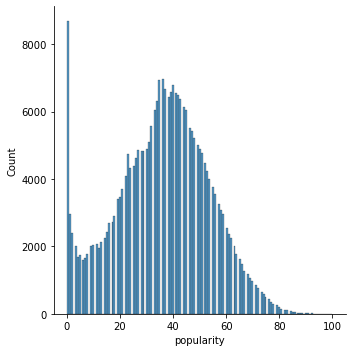

In [18]:
sns.displot(df["popularity"]);

### Duration, danceability and energy 

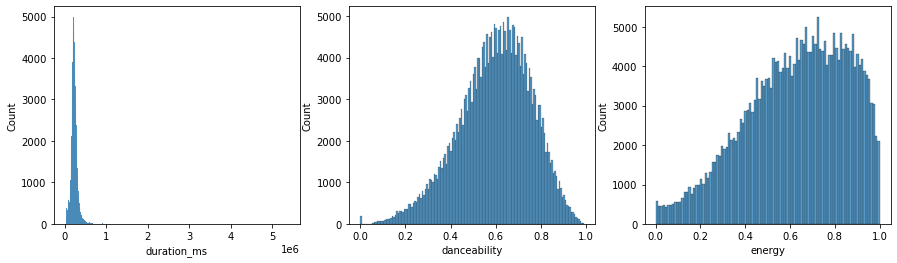

In [19]:
fig, ax = plt.subplots(1,3, figsize = (15,4));
sns.histplot(df["duration_ms"], ax = ax[0]);
sns.histplot(df["danceability"], ax = ax[1]);
sns.histplot(df["energy"], ax = ax[2]);

### Key, loudness and mode

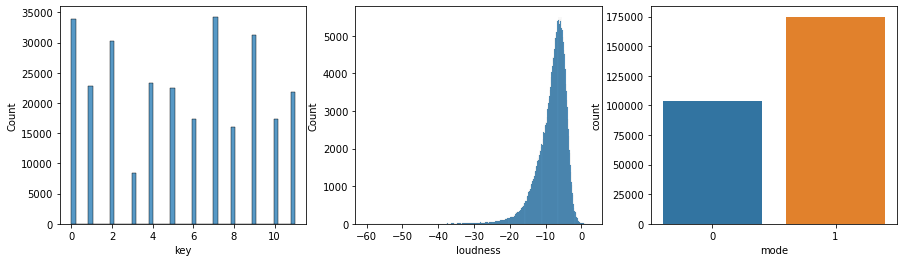

In [20]:
fig, ax = plt.subplots(1,3, figsize = (15,4));
sns.histplot(df["key"], ax = ax[0]);
sns.histplot(df["loudness"], ax = ax[1]);
sns.countplot(x = df["mode"], ax = ax[2]);

### Speechiness, acousticness and liveness

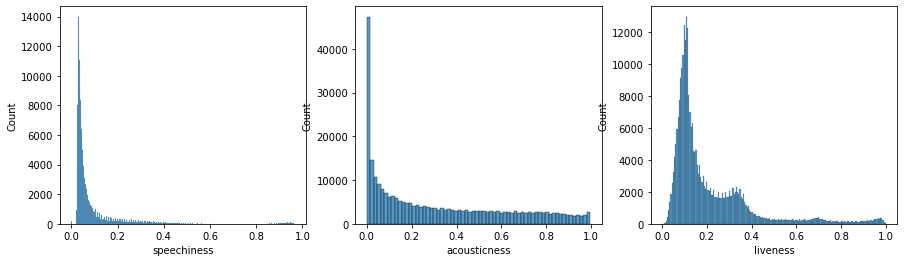

In [21]:
fig, ax = plt.subplots(1,3, figsize = (15,4));
sns.histplot(df["speechiness"], ax = ax[0]);
sns.histplot(df["acousticness"], ax = ax[1]);
sns.histplot(df["liveness"], ax = ax[2]);

### valence, tempo, time_signature

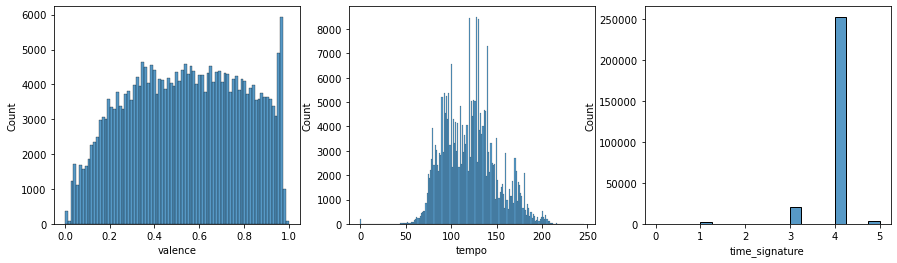

In [22]:
fig, ax = plt.subplots(1,3, figsize = (15,4));
sns.histplot(df["valence"], ax = ax[0]);
sns.histplot(df["tempo"], ax = ax[1]);
sns.histplot(x = df["time_signature"], ax = ax[2]);

### instrumentalness and explicit

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


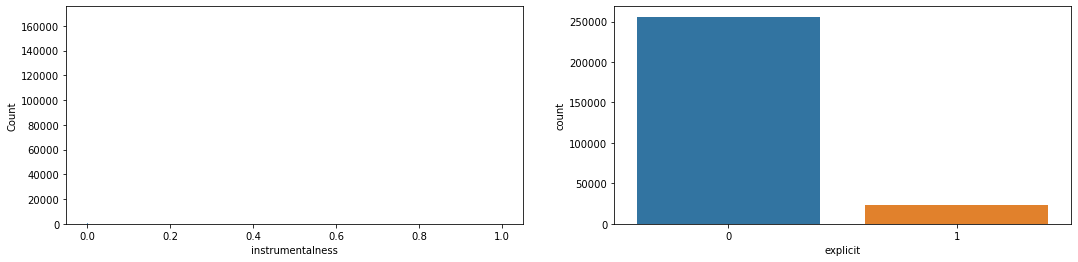

In [23]:
fig, ax = plt.subplots(1,2, figsize = (18,4));
sns.histplot(df["instrumentalness"], ax = ax[0]);
sns.countplot(df["explicit"], ax = ax[1]);

## 1.7 Encoding variables 


In [24]:
#encode release data as days since released
from data_processing import encode_date
df = encode_date(df)

## 1.8 Dividing sets into train, test, validation

In [25]:
from data_processing import split_data

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df)

## 1.9 Normalizing variables 

In [27]:
#normalize the features
from data_processing import normalize_data

In [28]:
X_train_n, X_val_n, X_test_n = normalize_data(X_train, X_val, X_test)

## 1.10 Feature Selection 

In [29]:
import sklearn.model_selection
from sklearn.ensemble import RandomForestRegressor


In [30]:
#random forest regressor to check for feature importance
regr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators = 10)
regr.fit(X_train_n, y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=0)

In [31]:
#checking permutation importance of features
feature_importances_permutations = permutation_importance(
    regr, X_train_n, y_train, scoring="neg_mean_squared_error"
)

In [32]:
sorted_idx = feature_importances_permutations.importances_mean.argsort()

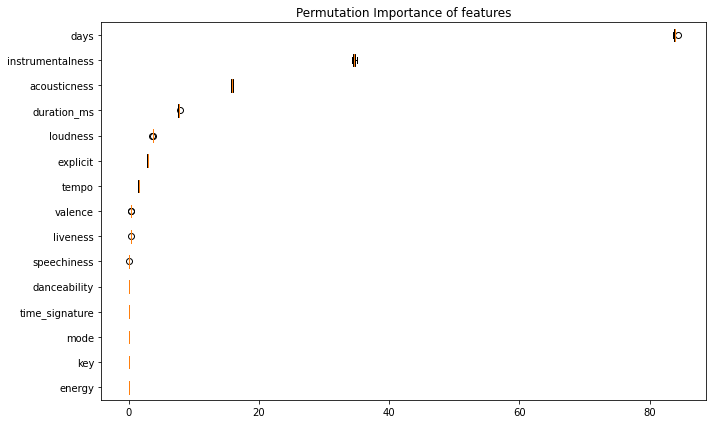

In [33]:
fig, ax = plt.subplots(figsize = (10,6))
ax.boxplot(feature_importances_permutations.importances[sorted_idx].T,
           vert=False,
          labels=X_train_n.columns[sorted_idx])
ax.set_title("Permutation Importance of features")
fig.tight_layout()
plt.show()

In [34]:
features = X_train_n.columns

In [35]:
features_selected = list(features[feature_importances_permutations.importances_mean >= 1])

In [36]:
features_selected

['duration_ms',
 'explicit',
 'loudness',
 'acousticness',
 'instrumentalness',
 'tempo',
 'days']

In [37]:
#features selected are passed and the data is filtered
from data_processing import select_features

In [38]:
X_train_n2, X_val_n2, X_test_n2 = select_features(X_train_n, X_val_n, X_test_n, features_selected)

# 2. Predictive Modeling 

In [189]:
#Combine training and validation set for grid search cv to work
X_n2 = X_train_n2.append(X_val_n2)
X_n2.reset_index(drop = True, inplace = True)
y = y_train.append(y_val)
y.reset_index(drop = True, inplace = True)
split_index = [-1 if x in X_train_n2.index else 0 for x in X_n2.index]
pds = PredefinedSplit(test_fold = split_index)

In [190]:
summary = pd.DataFrame(columns = ["Classifier", "Training set RMSE", "Validation set RMSE"])

## 2.0 Null Model 
This model uses no features and predicts mean to minimize RMSE 

In [191]:
#predicting mean value of target as it is the single value which gives the least RMSE
y_train_mean  = np.mean(y_train)
train_rmse = np.round(mean_squared_error([y_train_mean] * y_train.shape[0], y_train, squared = False), 2)
val_rmse = np.round(mean_squared_error([y_train_mean] * y_val.shape[0], y_val, squared = False), 2)

In [192]:
summary = summary.append({"Classifier":"Null Model", "Training set RMSE":train_rmse, "Validation set RMSE": val_rmse}, ignore_index = True)

In [193]:
summary

,Classifier,Training set RMSE,Validation set RMSE
0,Null Model,17.71,17.48


## 2.1 Linear Models 

In [194]:
#creating model object
lr = Ridge()

In [195]:
#declaring value of alpha
parameters = {'alpha':[0,0.1,0.5,1,2,5,10,100, 1000]}

In [196]:
#creating GridSearchCV object
clf = GridSearchCV(lr, parameters, scoring = 'neg_root_mean_squared_error', cv = pds)
clf.fit(X_n2, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Ridge(),
             param_grid={'alpha': [0, 0.1, 0.5, 1, 2, 5, 10, 100, 1000]},
             scoring='neg_root_mean_squared_error')

In [197]:
clf.best_params_

{'alpha': 1000}

In [198]:
clf.cv_results_

{'mean_fit_time': array([0.06460357, 0.02746487, 0.02803779, 0.02756715, 0.02783179,
        0.0276854 , 0.02841973, 0.02843094, 0.02755785]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.00264096, 0.00256944, 0.00258923, 0.00250626, 0.00252867,
        0.00255156, 0.00255942, 0.00260735, 0.00255132]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_alpha': masked_array(data=[0, 0.1, 0.5, 1, 2, 5, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0},
  {'alpha': 0.1},
  {'alpha': 0.5},
  {'alpha': 1},
  {'alpha': 2},
  {'alpha': 5},
  {'alpha': 10},
  {'alpha': 100},
  {'alpha': 1000}],
 'split0_test_score': array([-16.74947145, -16.74937384, -16.74898465, -16.74850093,
        -16.74754254, -16.74473751, -16.74028113, -16.68749109,
        -16.59486297]),
 'mean_test_score':

In [199]:
#fitting the model with the best params to the training data
lr2 = Ridge(alpha = 1000)
lr2.fit(X_train_n2, y_train)

Ridge(alpha=1000)

In [200]:
train_rmse = mean_squared_error(lr2.predict(X_train_n2), y_train, squared = False)
val_rmse = mean_squared_error(lr2.predict(X_val_n2), y_val, squared = False)
summary = summary.append({"Classifier":"Linear Regression", "Training set RMSE":train_rmse, "Validation set RMSE": val_rmse}, ignore_index = True)

In [201]:
summary

,Classifier,Training set RMSE,Validation set RMSE
0,Null Model,17.710000,17.480000
1,Linear Regression,16.511983,16.594863


## 2.2 Tree based models 

### 2.2.1 Decision Trees 

In [202]:
#creating model object
dt = DecisionTreeRegressor()

In [203]:
parameters = {'max_depth':[1,2,5,10,15], 'ccp_alpha':[0,0.01,0.1,1]}

In [204]:
clf = GridSearchCV(dt, parameters, scoring = 'neg_root_mean_squared_error', cv = pds)
clf.fit(X_n2, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1],
                         'max_depth': [1, 2, 5, 10, 15]},
             scoring='neg_root_mean_squared_error')

In [205]:
clf.best_params_

{'ccp_alpha': 0.1, 'max_depth': 10}

In [206]:
clf.cv_results_

{'mean_fit_time': array([0.23869562, 0.34796762, 0.82196426, 1.61415243, 2.29768014,
        0.18328381, 0.34674525, 0.8271246 , 1.62438512, 2.84315753,
        0.18451405, 0.34500051, 0.84027267, 1.60653257, 2.8530798 ,
        0.18174171, 0.34797931, 0.84702563, 1.6474061 , 2.89053535]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'mean_score_time': array([0.00283265, 0.00275278, 0.00287628, 0.00289917, 0.00304127,
        0.0026238 , 0.00273561, 0.00275588, 0.00280476, 0.00305772,
        0.00280762, 0.00263286, 0.00282955, 0.00268173, 0.00272608,
        0.00271773, 0.00281048, 0.00272083, 0.00275755, 0.00291252]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'param_ccp_alpha': masked_array(data=[0, 0, 0, 0, 0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1,
                    0.1, 0.1, 0.1, 1, 1, 1, 1, 1],
              mask=[False, False, False, 

In [207]:
dt = DecisionTreeRegressor(ccp_alpha = 0.1, max_depth = 10, random_state = 24)
dt.fit(X_train_n2, y_train)

DecisionTreeRegressor(ccp_alpha=0.1, max_depth=10, random_state=24)

In [208]:
train_rmse = mean_squared_error(dt.predict(X_train_n2), y_train, squared = False)
val_rmse = mean_squared_error(dt.predict(X_val_n2), y_val, squared = False)
summary = summary.append({"Classifier":"Decision Tree", "Training set RMSE":train_rmse, "Validation set RMSE": val_rmse}, ignore_index = True)

In [209]:
summary

,Classifier,Training set RMSE,Validation set RMSE
0,Null Model,17.710000,17.480000
1,Linear Regression,16.511983,16.594863
2,Decision Tree,15.187778,16.055428


### 2.2.2 Random Forest 

In [210]:
#creating model object
rf = RandomForestRegressor(n_estimators = 10)

In [233]:
parameters = {'max_depth':[5,10,15,20], 'ccp_alpha':[0,0.01,0.1,0.5], "max_features" : [None, "sqrt"]}

In [234]:
clf = GridSearchCV(rf, parameters, scoring = 'neg_root_mean_squared_error', cv = pds)
clf.fit(X_n2, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestRegressor(ccp_alpha=0.1, max_depth=15,
                                             max_features=None,
                                             n_estimators=10),
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 0.5],
                         'max_depth': [5, 10, 15, 20],
                         'max_features': [None, 'sqrt']},
             scoring='neg_root_mean_squared_error')

In [235]:
clf.best_params_

{'ccp_alpha': 0.1, 'max_depth': 10, 'max_features': None}

In [236]:
clf.cv_results_

{'mean_fit_time': array([ 5.54830766,  1.82156968, 10.48288274,  3.36428928, 14.82553792,
         4.62366796, 18.47700381,  6.06202602,  5.63266706,  1.83343291,
        10.64486074,  3.51411843, 19.11041307,  8.0984745 , 90.46976542,
        61.75648737,  5.49140453,  1.76005411, 10.56355262,  3.44197345,
        19.52697444,  7.95418239, 89.54238009, 65.12784386,  5.60002589,
         1.94588256, 10.68373704,  3.34768581, 19.39745259,  8.28825021,
        92.79948664, 63.37721848]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.00483608, 0.00465536, 0.00529027, 0.00525451, 0.0066011 ,
        0.00654936, 0.00846434, 0.00834846, 0.00458074, 0.00464201,
        0.00513601, 0.00506759, 0.00569105, 0.00572157, 0.0063374 ,
        0.00592422, 0.00454378, 0.00459599, 0.00499511, 0.00501251,
        0.00470972, 0.00505447, 0.00474524, 0.00473475, 

In [237]:
rf  = RandomForestRegressor(n_estimators = 10,ccp_alpha = 0.1, max_depth = 10, max_features = None)
rf.fit(X_train_n2, y_train)

RandomForestRegressor(ccp_alpha=0.1, max_depth=10, max_features=None,
                      n_estimators=10)

In [238]:
train_rmse = mean_squared_error(rf.predict(X_train_n2), y_train, squared = False)
val_rmse = mean_squared_error(rf.predict(X_val_n2), y_val, squared = False)
summary = summary.append({"Classifier":"Random Forest", "Training set RMSE":train_rmse, "Validation set RMSE": val_rmse}, ignore_index = True)

In [246]:
summary

,Classifier,Training set RMSE,Validation set RMSE
0,Null Model,17.710000,17.480000
1,Linear Regression,16.511983,16.594863
2,Decision Tree,15.187778,16.055428
3,Random Forest,15.064200,15.797037


### 2.2.3 XGBoost

In [247]:
#saving data as a cvs file
train_set = pd.concat([y_train, X_train_n2], axis = 1)
validation_set = pd.concat([y_val, X_val_n2], axis = 1)
test_set = pd.concat([y_test, X_test_n2], axis = 1)
train_set.to_csv("Spotify_Data/train_set.csv", header = False, index = False)
X_train_n2.to_csv("Spotify_Data/X_train_n2.csv", header = False, index = False)
validation_set.to_csv("Spotify_Data/validation_set.csv", header = False, index = False)
X_val_n2.to_csv("Spotify_Data/X_val_n2.csv", header = False, index = False)
test_set.to_csv("Spotify_Data/test_set.csv", header = False, index = False)

In [248]:
#creating a session
#passing xgboost container to run
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session() 

role = get_execution_role()
bucket = session.default_bucket()
xgboost_container = sagemaker.image_uris.retrieve("xgboost", session.boto_region_name, "1.2-2")


In [249]:
# data dir to retrieve saved features data
data_dir = 'Spotify_Data'

# S3 directory prefix
prefix = 'Capstone_Project'

# upload all data to S3
test_location = session.upload_data(os.path.join(data_dir, 'test_set.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation_set.csv'), key_prefix=prefix)
val_location2 = session.upload_data(os.path.join(data_dir, 'X_val_n2.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train_set.csv'), key_prefix=prefix)
train_location2 = session.upload_data(os.path.join(data_dir, 'X_train_n2.csv'), key_prefix=prefix)

In [250]:
#creating model object
xgb = sagemaker.estimator.Estimator(xgboost_container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=50)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [251]:
from sagemaker.inputs import TrainingInput

In [252]:
s3_input_train = TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = TrainingInput(s3_data=val_location, content_type='csv')

In [253]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

# Creating hyperparameter tuner object

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 6, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(5, 10),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [254]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

.........................................................................................................................!


In [255]:
xgb_hyperparameter_tuner

In [256]:
#creating model object with the best hyper parameters
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())


2021-08-15 14:51:10 Starting - Preparing the instances for training
2021-08-15 14:51:10 Downloading - Downloading input data
2021-08-15 14:51:10 Training - Training image download completed. Training in progress.
2021-08-15 14:51:10 Uploading - Uploading generated training model
2021-08-15 14:51:10 Completed - Training job completed


In [257]:
#batch process training and validation jobs
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [258]:
xgb_transformer.transform(train_location2,  content_type='text/csv', split_type='Line')

...................................[2021-08-15:14:58:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-15:14:58:20:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-15:14:58:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


[2021-08-15 14:58:20 +0000] [19] [INFO

In [280]:
xgb_transformer.model_name

'sagemaker-xgboost-2021-08-15-14-52-37-656'

In [260]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir
predictions = pd.read_csv(os.path.join(data_dir, 'X_train_n2.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

download: s3://sagemaker-us-east-1-597418338686/sagemaker-xgboost-2021-08-15-14-52-38-081/X_train_n2.csv.out to Spotify_Data/X_train_n2.csv.out


In [261]:
train_rmse = mean_squared_error(predictions, y_train, squared = False)

In [262]:
train_rmse

15.001210786084785

In [263]:
xgb_transformer.transform(val_location2,  content_type='text/csv', split_type='Line')

...................................[2021-08-15:15:04:35:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-15:15:04:35:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-15:15:04:35:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


[2021-08-15 15:04:35 +0000] [19] [INFO

In [264]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir
predictions = pd.read_csv(os.path.join(data_dir, 'X_val_n2.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

download: s3://sagemaker-us-east-1-597418338686/sagemaker-xgboost-2021-08-15-14-58-53-919/X_val_n2.csv.out to Spotify_Data/X_val_n2.csv.out


In [265]:
val_rmse = mean_squared_error(predictions, y_val, squared = False)

In [266]:
summary = summary.append({"Classifier":"XGBoost", "Training set RMSE":train_rmse, "Validation set RMSE": val_rmse}, ignore_index = True)

In [267]:
summary

,Classifier,Training set RMSE,Validation set RMSE
0,Null Model,17.710000,17.480000
1,Linear Regression,16.511983,16.594863
2,Decision Tree,15.187778,16.055428
3,Random Forest,15.064200,15.797037
4,XGBoost,15.001211,15.875988


## 3. K-Nearest Neighbors 

In [281]:
#creating model object
knn = KNeighborsRegressor()

In [282]:
parameters = {'n_neighbors':[10,50, 100,200,500], 'weights':["distance", "uniform"]}

In [283]:
clf = GridSearchCV(knn, parameters, scoring = 'neg_root_mean_squared_error', cv = pds)
clf.fit(X_n2, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 50, 100, 200, 500],
                         'weights': ['distance', 'uniform']},
             scoring='neg_root_mean_squared_error')

In [284]:
clf.cv_results_

{'mean_fit_time': array([79.55018568, 80.08774757, 80.00764489, 80.06830239, 79.71821666,
        80.10939503, 79.83831382, 79.88301158, 79.89936304, 80.08038187]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.19326425, 0.20025516, 0.3034265 , 0.27112103, 0.40337133,
        0.39055729, 0.48407197, 0.4836123 , 0.75606537, 0.72430611]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_n_neighbors': masked_array(data=[10, 10, 50, 50, 100, 100, 200, 200, 500, 500],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['distance', 'uniform', 'distance', 'uniform',
                    'distance', 'uniform', 'distance', 'uniform',
                    'distance', 'uniform'],
              mask=[False, False, False, False, False, False, False, False,
                    Fals

In [291]:
clf.best_params_

{'n_neighbors': 200, 'weights': 'distance'}

In [292]:
knn  = KNeighborsRegressor(n_neighbors = 200, weights = "distance")
knn.fit(X_train_n2, y_train)

KNeighborsRegressor(n_neighbors=200, weights='distance')

In [293]:
train_rmse = mean_squared_error(knn.predict(X_train_n2), y_train, squared = False)
val_rmse = mean_squared_error(knn.predict(X_val_n2), y_val, squared = False)
summary = summary.append({"Classifier":"K-Nearest Neighbors", "Training set RMSE":train_rmse, "Validation set RMSE": val_rmse}, ignore_index = True)

In [295]:
summary

,Classifier,Training set RMSE,Validation set RMSE
0,Null Model,17.710000,17.480000
1,Linear Regression,16.511983,16.594863
2,Decision Tree,15.187778,16.055428
3,Random Forest,15.064200,15.797037
4,XGBoost,15.001211,15.875988
5,K-Nearest Neighbors,1.171800,15.889946
6,K-Nearest Neighbors,1.171800,15.806331


## Deployment 

In [315]:
summary_test = pd.DataFrame(columns = ["Classifier", "Test set RMSE"])

In [316]:
y_test_mean  = np.mean(y_test)
test_rmse = np.round(mean_squared_error([y_test_mean] * y_test.shape[0], y_test, squared = False), 2)

In [317]:
summary_test = summary_test.append({"Classifier":"Null Model","Test set RMSE": test_rmse}, ignore_index = True)

In [318]:
summary_test

,Classifier,Test set RMSE
0,Null Model,16.91


### Deploying Random Forest

In [319]:
X_test_n2.to_csv("Spotify_Data/X_test_n2.csv", header = False, index = False)

In [320]:
test_location2 = session.upload_data(os.path.join(data_dir, 'X_test_n2.csv'), key_prefix=prefix)

In [321]:
from sagemaker.sklearn.estimator import SKLearn

# specify an output path
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate RandomForest model object from train.py script
estimator = SKLearn(entry_point = 'train.py',
                 source_dir = 'source_sklearn',
                 role=role,
                 train_instance_count=1, 
                 py_version = 'py3',
                 framework_version = '0.23-1',
                 instance_type = 'ml.c4.xlarge',
                 sagemaker_session = session,
                 output_path = output_path,)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [322]:
%%time

# Train estimator on S3 training data
estimator.fit({'train': s3_input_train})

2021-08-15 18:03:06 Starting - Starting the training job...
2021-08-15 18:03:08 Starting - Launching requested ML instancesProfilerReport-1629050586: InProgress
...
2021-08-15 18:04:03 Starting - Preparing the instances for training.........
2021-08-15 18:05:35 Downloading - Downloading input data...
2021-08-15 18:05:56 Training - Downloading the training image..
2021-08-15 18:06:36 Uploading - Uploading generated training model2021-08-15 18:06:21,180 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-08-15 18:06:21,183 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-15 18:06:21,193 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-08-15 18:06:21,554 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-15 18:06:21,567 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-15 18:06:21,580 sagemaker-tr

In [323]:
#deploy the model
rf_predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-----------------!

In [324]:
test_rmse = mean_squared_error(rf_predictor.predict(X_test_n2), y_test, squared = False)

In [325]:
summary_test = summary_test.append({"Classifier":"Random Forest","Test set RMSE": test_rmse}, ignore_index = True)

In [326]:
summary_test

,Classifier,Test set RMSE
0,Null Model,16.910000
1,Random Forest,14.981915


### Deploying K-Nearest Neighbors

In [310]:
from sagemaker.sklearn.estimator import SKLearn

# specify an output path
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate K-Nearest Neighbots model object from train.py script
estimator = SKLearn(entry_point = 'train2.py',
                 source_dir = 'source_sklearn',
                 role=role,
                 train_instance_count=1, 
                 py_version = 'py3',
                 framework_version = '0.23-1',
                 instance_type = 'ml.c4.xlarge',
                 sagemaker_session = session,
                 output_path = output_path,)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [311]:
%%time

# Train estimator on S3 training data
estimator.fit({'train': s3_input_train})

2021-08-15 17:33:15 Starting - Starting the training job...
2021-08-15 17:33:39 Starting - Launching requested ML instancesProfilerReport-1629048795: InProgress
...
2021-08-15 17:34:10 Starting - Preparing the instances for training.........
2021-08-15 17:35:39 Downloading - Downloading input data...
2021-08-15 17:35:59 Training - Downloading the training image..2021-08-15 17:36:23,956 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-08-15 17:36:23,959 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-15 17:36:23,968 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-08-15 17:36:24,432 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-15 17:36:25,861 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-08-15 17:36:25,873 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus install

In [312]:
#deploy the model
knn_predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------------!

In [330]:
test_rmse = mean_squared_error(knn_predictor.predict(X_test_n2), y_test, squared = False)

In [331]:
test_rmse

14.78046842804002

In [332]:
summary_test = summary_test.append({"Classifier":"K-Nearest Neighbors","Test set RMSE": test_rmse}, ignore_index = True)

In [337]:
summary_test

,Classifier,Test set RMSE
0,Null Model,16.910000
1,Random Forest,14.981915
2,K-Nearest Neighbors,14.780468


In [338]:
predictions = knn_predictor.predict(X_test_n2)

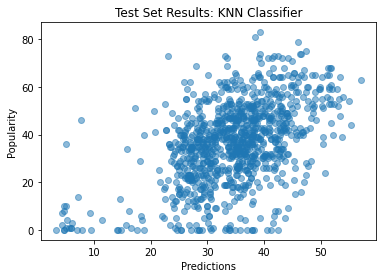

In [352]:
plt.plot(figsize = (20,4));
plt.scatter(predictions, y_test, alpha = 0.5)
plt.xlabel("Predictions")
plt.ylabel("Popularity")
plt.title("Test Set Results: KNN Classifier");